# Bitbubble

Simplified ABM model that links the **"How to grow a bubble: A model of myopic adapting agents"** with the **"Leader–follower model for agent based simulation of social collective behavior during egress"** in the bitcoin bubble model space

In [1]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
from mesa import Agent, Model
import matplotlib.pyplot as plt
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
%matplotlib inline
#print(mpl.style.available)
mpl.style.use('ggplot')
#plt.xkcd()
np.random.seed(seed=42)

In [2]:
class MarketMaker(Model):
    """A model with some number of investors."""
    def __init__(self, N, market_depth, alpha=0.95, k=4, seed=None):
        super().__init__(seed)
        self.schedule = RandomActivation(self)
        self.N = N
        self.market_depth = market_depth
        self.alpha = alpha
        self.t = 0
        self.current_price = 1
        self.list_price = [self.current_price]
        self.list_return = [1]
        self.list_sp_return = [1]
        self.list_sigma_return = [1]
        self.list_news = []
        self.list_u = [0]
        self.current_orders = []
        self.G = self.create_network(k)
        # Create agents
        for i in self.G.nodes():
            a = Investor(i, self)
            self.G.add_node(i)
            self.schedule.add(a)
            
        self.datacollector = DataCollector(
            model_reporters = {"price": "current_price"
                            , "r": "r"
                            , "sigma_r": "sigma_r"
                            , "u": "u"
                            , "n": "news"},   
            agent_reporters = {"cash": "cash"
                            , "coins": "coins"
                            , "opinion": "opinion"
                            , "action": "current_action"
                            , "volume": "current_volume"
                            , "k": "neighbors_trust"})
            
    def step(self):
        '''Advance the model by one step.'''
        self.t = self.t + 1
        self.current_orders = list([])
        "Agents: move!"
        self.schedule.step()
        "After the orders, recalc the price of the asset"
        self.r = self.get_return()
        self.list_return.append(self.r)
        self.current_price = self.calc_price(self.r)
        self.list_price.append(self.current_price)
        self.list_sp_return.append(self.get_special_r(self.t))
        self.sigma_r = self.get_sigma_r(self.t)
        self.list_sigma_return.append(self.sigma_r)
        "Update wealth of agents with the new price"
        for a in self.schedule.agents:
            a.update_wealth(self.current_price)
        """TODO add end conditions (basic, upper limit, lower limit)"""
        if len([i for i, e in enumerate(self.current_orders) if e != 0]) > 0:
            #print("orders for t", self.t, self.r)
            pass
        self.datacollector.collect(self)
        
    def create_network(self, num_edges):
        '''Creates a Barabasi-Albert network with the number of agents and edges.'''
        return nx.generators.random_graphs.barabasi_albert_graph(self.N, num_edges)
    
    def newspaper(self, t):
        available_news = len(self.list_news)
        if available_news <= t:
            for i in range(0, t - (available_news - 1)):
                self.news = np.random.normal()
                self.list_news.append(self.news)
        return self.list_news[t]
    
    def get_price(self, t):
        price = self.list_price[0]
        if t > 0 and t < len(self.list_price):
            price = self.list_price[t]
        return price
    
    def add_order(self, unique_id, s=0, v=0.0):
        self.current_orders.append(s*v)
        
    def get_return(self):
        total = sum(self.current_orders)
        return total / (self.market_depth * self.N)
    
    def calc_price(self, r):
        price = np.exp(np.log(self.current_price) + r)
        return price
    
    def get_special_r(self, t):
        sp_r = self.list_sp_return[0]
        if t > 0 and t <= len(self.list_sp_return):
            sp_r = self.alpha * self.list_sp_return[t-1] + (1-self.alpha) * self.list_return[t-1]
        return sp_r
    
    def get_sigma_r(self, t):
        sigma_r = self.list_sigma_return[0]
        if t > 0 and t <= len(self.list_sigma_return):
            sigma_r = np.sqrt(
                self.alpha * np.square(self.list_sigma_return[t-1])
                + (1-self.alpha) * np.square(self.list_return[t-1] - self.list_sp_return[t-1])
            )
        return sigma_r
    
    def get_news_factor(self, t):
        self.u = self.list_u[0]
        if len(self.list_u) > t:
            self.u = self.list_u[t]
        elif t <= len(self.list_u):
            prev_u = self.list_u[t - 1]
            self.u = (self.alpha * prev_u) + ((1 - self.alpha) * self.newspaper(t - 1))
            self.list_u.append(self.u)
            
            
        return self.u

In [3]:
class Investor(Agent):
    """An investor with fixed initial cash and coins."""
    def __init__(self, unique_id, model, C1=1, C2=1, C3=1
                 , Omega=2, g=0.02, cash=1.0, coins=1.0):
        super().__init__(unique_id, model)
        self.cash = cash
        self.coins = coins
        self.Omega = Omega
        self.g = g
        #TODO: how to generate closed interval random numbers?
        self.c1 = np.random.uniform(0.0, C1)
        self.c2 = np.random.uniform(0.0, C1)
        self.c3 = np.random.uniform(0.0, C3)
        self.w_min = np.random.uniform(0.0, Omega)
        
        self.current_action = 0
        self.current_volume = 0
        self.list_opinions = [0]
        self.list_actions = [0]
        self.list_volumes = [0]
        self.list_cash = [self.cash]
        self.list_coins = [self.coins]
        self.dict_k = self.init_neighbors_k()
        self.private_info = [self.collect_private_info()]
        
    def step(self):
        time = self.model.t
        self.E = self.collect_private_info()
        self.private_info.append(self.E)
        self.opinion = self.get_market_opinion(self.E)
        self.list_opinions.append(self.opinion)
        self.current_action, self.current_volume = self.get_actions(self.opinion, time)
        self.list_actions.append(self.current_action)
        self.list_volumes.append(self.current_volume)
        self.model.add_order(self.unique_id, self.current_action, self.current_volume)
        
    def collect_private_info(self):
        return np.random.normal()
    
    def get_market_opinion(self, E):
        t = self.model.t
        self.neighbors_trust = sum( self.calc_neighbors_trust(t) )
        network_effect = (self.c1) * self.neighbors_trust
        news_effect = (self.c2 * self.model.get_news_factor(t-1) * self.model.newspaper(t))
        idiosyncratic = (self.c3 * E)
        opinion = network_effect + news_effect + idiosyncratic
        
        return opinion
    
    def calc_neighbors_trust(self, t):
        res = []
        for neighbor in self.get_neighbors():
            k_factor = self.get_neighbor_factor(neighbor, t-1)
            n_action = self.get_neighbor_action(neighbor, t)
            res.append(k_factor * n_action)
        return res
        
    def get_neighbors(self):
        return [t[1] for t in self.model.G.edges(self.unique_id)]
    
    def init_neighbors_k(self):
        res = {}
        for n in self.get_neighbors():
            res[n] = [0]
            
        return res
        
    def get_neighbor_factor(self, neighbor_id, time):
        alpha = self.model.alpha
        k = self.dict_k[neighbor_id][0]
        prev_k_list = self.dict_k[neighbor_id]
        prev_k = prev_k_list[0]
        prev_n_action = self.get_neighbor_action(neighbor_id, 0)
        r = self.model.list_return[time]
        sigma_r = self.model.list_sigma_return[time]
        if time > 0 and time <= len(self.dict_k[neighbor_id]):
            prev_k = prev_k_list[time - 1]
            prev_n_action = self.get_neighbor_action(neighbor_id, time - 1)
            first_term = (alpha * prev_k)
            second_term = ((1-alpha) * prev_n_action * r/sigma_r)
            k = first_term + second_term
            prev_k_list.append(k)
            if r != 0 and sigma_r>0 and prev_n_action !=0:
                #print(self.unique_id, time, neighbor_id, "prev_n_action", prev_n_action, "k", k
                #     , "ft", first_term, "r/sigma", r/sigma_r)
                pass

        return k
    
    def get_neighbor_action(self, neighbor_id, time):
        nb_action = random.choice([-1,0,1])
        for a in self.model.schedule.agents:
            if a.unique_id == neighbor_id:
                if time > 0 and time < len(a.list_actions):
                    nb_action = a.list_actions[time-1]
                    
        return nb_action
    
    def get_actions(self, opinion, time):
        s = 0
        v = 0
        if opinion >= self.w_min:
            s = 1
            v = self.g * self.cash / self.model.get_price(time-1)
        elif opinion <= self.w_min * (-1):
            s = -1
            v = self.g * self.coins
        return s, v
        
    def update_wealth(self, price):
        self.cash = self.cash - self.current_action * self.current_volume * price
        self.list_cash.append(self.cash)
        self.coins = self.coins + self.current_action * self.current_volume
        self.list_coins.append(self.coins)
        

## Paper test results
Attempt to replicate the basic (Fig. 1) results with our implementation

In [34]:
bitmarket = MarketMaker(250, 0.25, seed=42)
for i in range(2000):
    bitmarket.step()

In [35]:
df_model = bitmarket.datacollector.get_model_vars_dataframe()
df_agents = bitmarket.datacollector.get_agent_vars_dataframe()

Text(0.5,1,'Price over time')

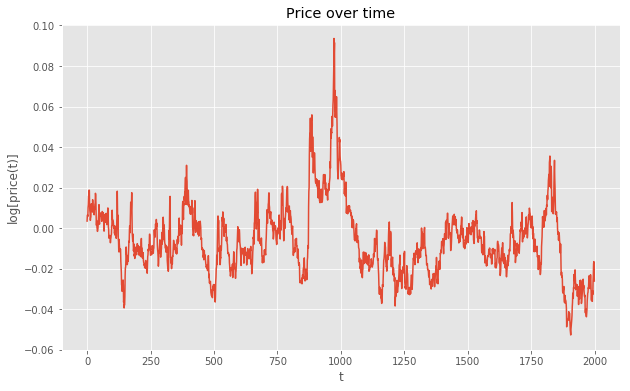

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(np.log(df_model.price))
ax.set(ylabel='log[price(t)]', xlabel='t')
plt.title('Price over time')

Text(0.5,1,'Return over time')

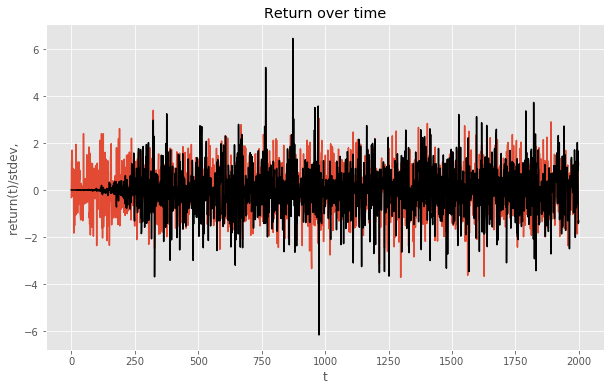

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(df_model.n)
ax.plot(df_model.r/df_model.sigma_r, color='#000000')
ax.set(ylabel='return(t)/stdev, ', xlabel='t')
plt.title('Return over time')

Text(0.5,1,'News factor over time')

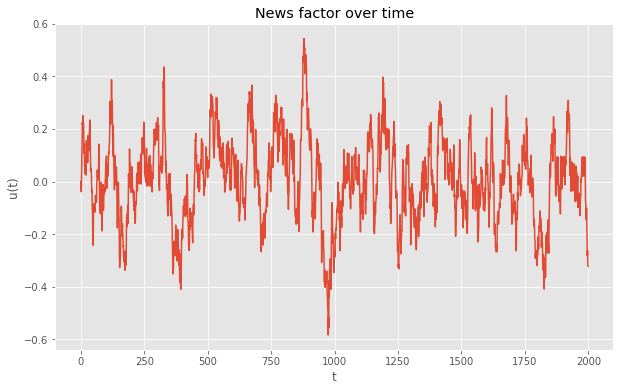

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(df_model.u)
ax.set(ylabel='u(t)', xlabel='t')
plt.title('News factor over time')

Text(0.5,1,'Histogram of returns')

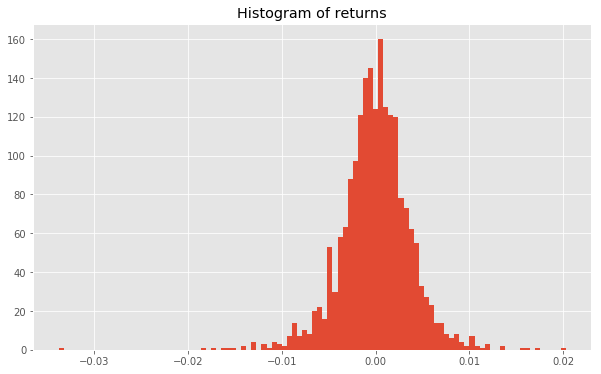

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(df_model.r, bins=100, log=False)
plt.title('Histogram of returns')

In [31]:
df_k = pd.DataFrame(df_agents.k).reset_index()
mean_k = []
for n, grp in df_k.groupby('Step'):
    mean_k.append(np.mean(grp.k))

Text(0.5,1,'<Kij>(t)')

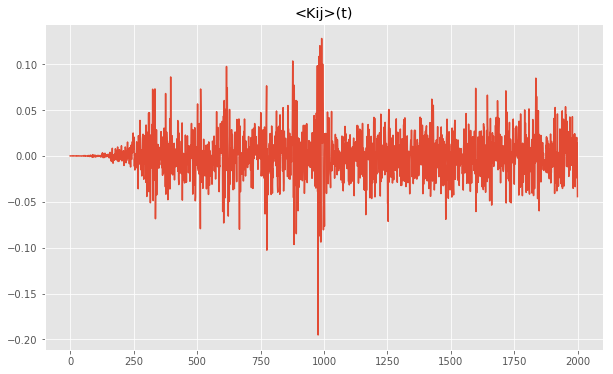

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(mean_k)
plt.title('<Kij>(t)')

Text(0.5,1,'Autocorrelations')

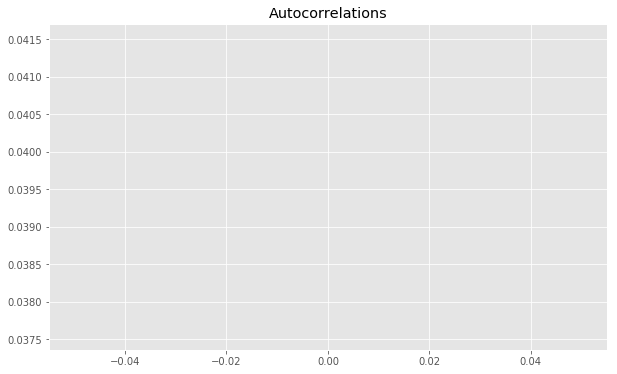

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
autocorr_r = np.correlate(df_model.r, df_model.r)
autocorr_abs_r = np.correlate(np.absolute(df_model.r), np.absolute(df_model.r))
ax.plot(autocorr_r)
ax.plot(autocorr_abs_r)
plt.title('Autocorrelations')

## Modifications to add diffusion